In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow_io as tfio
import librosa as librosa
from librosa import display
import numpy as np

# Load the data

In [11]:
from google.colab import drive
drive.mount('/content/drive/')
main = '/content/drive/My Drive/Deep_Breath/'

diagnosis_df = pd.read_csv('/content/drive/My Drive/Deep_Breath/raw_data/archive/Respiratory_Sound_Database/patient_diagnosis.csv'
                            , names=['Patient number', "Diagnosis"])
diagnosis_df.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,Patient number,Diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Deep_Breath/raw_data/archive/Respiratory_Sound_Database/audio_and_txt_files/combined.txt'
                    , sep='\t', names = ['start', "end", 'crackles','wheezes', 'filename'])

for index, row in data.iterrows():
    temp_list = []
    temp_list.append(row['filename'].split("_"))
    data.loc[index, 'Patient number'] = temp_list[0][0]
    
data['Patient number'] =  data['Patient number'].astype(int)

In [ ]:
data.head()

,start,end,crackles,wheezes,filename,Patient number
0,0.036,0.579,0,0,101_1b1_Al_sc_Meditron.txt,101
1,0.579,2.450,0,0,101_1b1_Al_sc_Meditron.txt,101
2,2.450,3.893,0,0,101_1b1_Al_sc_Meditron.txt,101
3,3.893,5.793,0,0,101_1b1_Al_sc_Meditron.txt,101
4,5.793,7.521,0,0,101_1b1_Al_sc_Meditron.txt,101


# Understand the data - Diagnosis distribution 

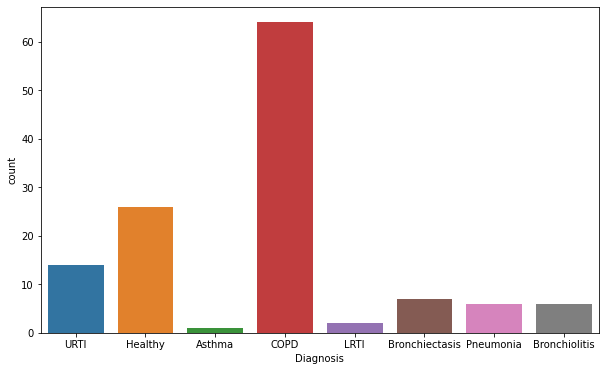

In [ ]:
'''Objective: understand the distribution of patient diagnosis'''
plt.figure(figsize=(10,6))
sns.countplot(x = diagnosis_df['Diagnosis']);

In [ ]:
'''Objective: merge the dataframes - diagnosis_df and data. 
Understand the distribution of diagnosis associated with respiratory cycle.'''

data = data.merge(diagnosis_df, on = 'Patient number')
data.head()

,start,end,crackles,wheezes,filename,Patient number,Diagnosis
0,0.036,0.579,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI
1,0.579,2.450,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI
2,2.450,3.893,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI
3,3.893,5.793,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI
4,5.793,7.521,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI


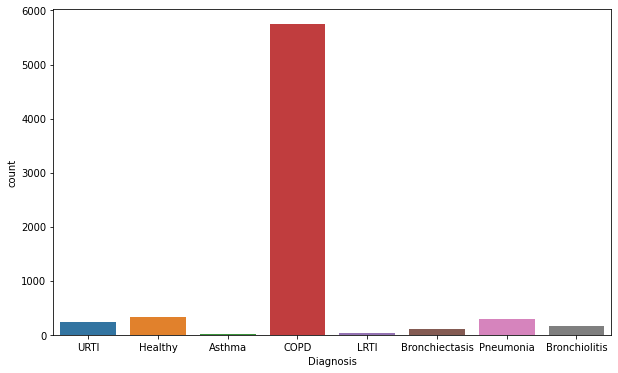

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x = data['Diagnosis']);

# Understand the data - distribution of normal/abnormal lung sound

In [ ]:
'''binary_sound_label : Normal lung sound = '0'; 
                        Any crackles/wheezes = '1' '''

'''multi_sound_label :  Normal lung sound = '0'; 
                        Only crackles = '1'; 
                        Only wheezes = '2', 
                        Both crackles and wheezes = '3' '''


def classification(df):
    for index, row in df.iterrows():
        if row['crackles'] + row['wheezes'] ==0:
            df.loc[index, 'binary_sound_label'] = 0
            df.loc[index, 'multi_sound_label'] = 0
        elif row['crackles'] > 0 and row['wheezes'] ==0:
            df.loc[index, 'binary_sound_label'] = 1
            df.loc[index, 'multi_sound_label'] = 1
        elif row['crackles'] == 0 and row['wheezes'] >0:
            df.loc[index, 'binary_sound_label'] = 1
            df.loc[index, 'multi_sound_label'] = 2
        else:
            df.loc[index, 'binary_sound_label'] = 1
            df.loc[index, 'multi_sound_label'] = 3

classification(data)

In [ ]:
data.head()

,start,end,crackles,wheezes,filename,Patient number,Diagnosis,binary_sound_label,multi_sound_label
0,0.036,0.579,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI,0.0,0.0
1,0.579,2.450,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI,0.0,0.0
2,2.450,3.893,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI,0.0,0.0
3,3.893,5.793,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI,0.0,0.0
4,5.793,7.521,0,0,101_1b1_Al_sc_Meditron.txt,101,URTI,0.0,0.0


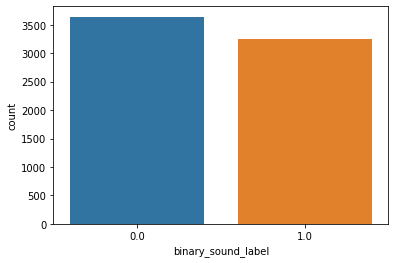

In [ ]:
sns.countplot(x = data['binary_sound_label']);

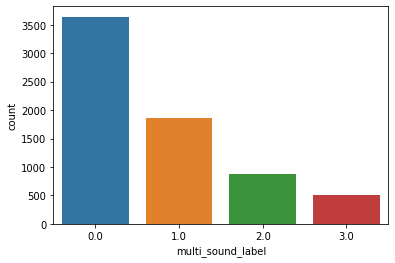

In [ ]:
sns.countplot(x = data['multi_sound_label']);

# Understand demographics

In [12]:
demo = main + 'raw_data/archive/demographic_info.txt'
demo_df = pd.read_csv(demo, sep=' ', header=None)
demo_df = demo_df.rename(columns = {0: 'Patient number', 1:'Age', 
                                    2:'Sex', 3:'Adult BMI(kg/m2)', 
                                    4:'Child Weight(kg)', 5:'Child Height(cm)'})

demo_df = demo_df.merge(diagnosis_df, on = 'Patient number')
demo_df.head()

,Patient number,Age,Sex,Adult BMI(kg/m2),Child Weight(kg),Child Height(cm),Diagnosis
0,101,3.00,F,NaN,19.0,99.0,URTI
1,102,0.75,F,NaN,9.8,73.0,Healthy
2,103,70.00,F,33.00,NaN,NaN,Asthma
3,104,70.00,F,28.47,NaN,NaN,COPD
4,105,7.00,F,NaN,32.0,135.0,URTI


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


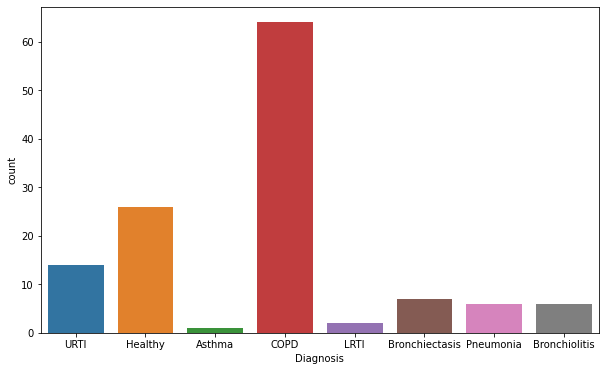

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(demo_df['Diagnosis']);

In [ ]:
'''checking any missing value'''
demo_df.isna().sum()

Patient number       0
Age                  1
Sex                  1
Adult BMI(kg/m2)    51
Child Weight(kg)    82
Child Height(cm)    84
Diagnosis            0
dtype: int64

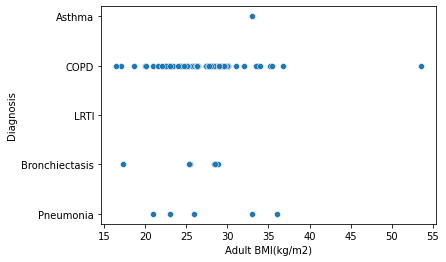

In [ ]:
'''Understand the relationship betwen diagnosis and BMI. Unable to identify any pattern.'''
sns.scatterplot(x= demo_df['Adult BMI(kg/m2)'], y=demo_df['Diagnosis']);

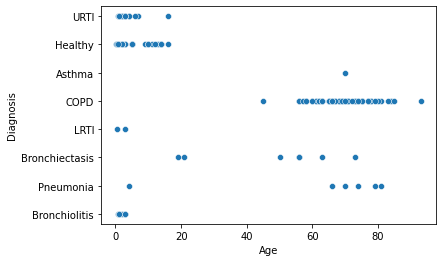

In [ ]:
'''Understand the relationship betwen diagnosis and Age. 
It appears that elder people have greater chance of getting COPD.'''

sns.scatterplot(x=demo_df['Age'], y= demo_df['Diagnosis']);

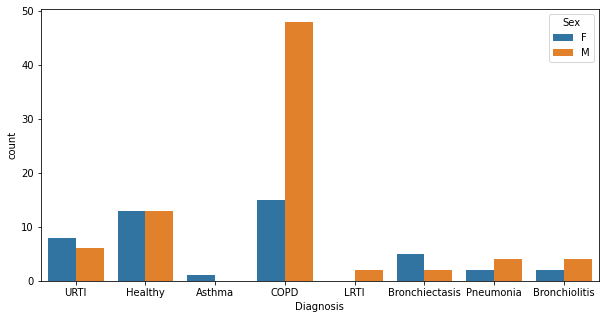

In [ ]:
''' More male patients were diagnosed with COPD in this dataset'''

plt.figure(figsize=(10, 5))
sns.countplot(x='Diagnosis', hue='Sex', data=demo_df);

# Plot Spectrograms
1 - TensorFlow


2 - Librosa

In [ ]:
txt_path= os.listdir('/content/drive/My Drive/Deep_Breath/processed_audio_files')
wavfile_name = [f for f in txt_path if f.endswith('.wav')]
wav_path = []

for x in range(len(wavfile_name)):
    temp = f'/content/drive/My Drive/Deep_Breath/processed_audio_files/{wavfile_name[x]}'
    wav_path.append(temp)

In [ ]:
'''TensorFlow'''
def generate_tensor(path_to_file):
  #reads audio, takes path as input, returns AudioIOTensor
  audio = tfio.audio.AudioIOTensor(path_to_file)
  #returns tf tensor, ready for spectogram generation function and convert to floats
  tensor = audio.to_tensor()
  tensor = tf.squeeze(tensor, axis=[-1])
  tensor = tf.cast(tensor, tf.float32)
  return tensor

In [ ]:
def generate_spectrogram(path_to_file):
  tensor = generate_tensor(path_to_file)
  spectrogram = tfio.audio.spectrogram(tensor, nfft=512, window=30, stride=240)
  spectrogram = tf.transpose(spectrogram, perm=[1, 0])
  return spectrogram

In [ ]:
def plot_spectrogram(path_to_file):
  spectrogram = generate_spectrogram(path_to_file)
  plt.figure(figsize=(10,3))
  plt.ylim((0,50))
  plt.imshow(spectrogram)

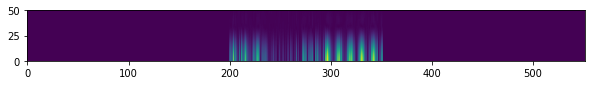

In [ ]:
plot_spectrogram(wav_path[3])

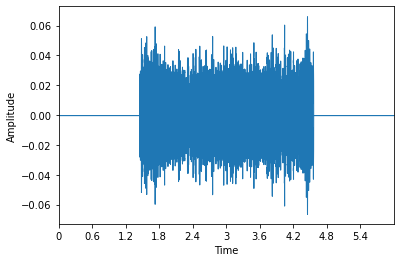

In [ ]:
'''Librosa'''
samples, sampling_rate = librosa.load(wav_path[0], sr=None)
plt.figure()
librosa.display.waveplot(y = samples, sr = sampling_rate)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

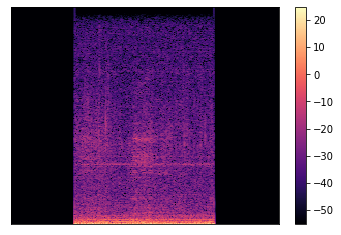

In [ ]:
fourier_transform = librosa.stft(samples)
magnitudes_in_db = librosa.amplitude_to_db(np.abs(fourier_transform))
plt.figure()
librosa.display.specshow(magnitudes_in_db)
plt.colorbar()